In [1]:
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt
import scienceplots

In [2]:
qml.drawer.use_style(style='sketch')

## Approximate time-evolution unitary

In this notebook, we will show how to implement an approximate time-evolution unitary operator using the Trotter-Suzuki decomposition. This is a common technique in quantum computing to simulate the time-evolution of a quantum system.

The unitary operator that we want to approximate is given by

$$
U = e^{-iHt},
$$

where $H$ is the Hamiltonian of the system and $t$ is the time.

For quantum circuit, the Hamiltonian usually is composed of a sum of other Hamiltonians:

$$
H = \sum_{i=1}^{n} H_i.
$$

The Trotter-Suzuki decomposition allows us to approximate the time-evolution operator $U$ as

$$
U(H, t, n) = \prod_{j=1}^{n} \prod_k e^{-iH_k t / n}, \quad H = \sum_{k=1}^{n} H_k. 
$$

where $U$ approches $e^{-iHt}$ as $n$ increases.

In [3]:
H = qml.Hamiltonian(
    [1, 1, 0.5],
    [qml.PauliX(0), qml.PauliZ(1), qml.PauliX(0) @ qml.PauliX(1)]
)

print(H)

1 * X(0) + 1 * Z(1) + 0.5 * (X(0) @ X(1))


In [4]:
dev = qml.device("default.qubit", wires=2)

t = 1
n = 2

@qml.qnode(dev)
def circuit(t, n):
    qml.ApproxTimeEvolution(H, t, n)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

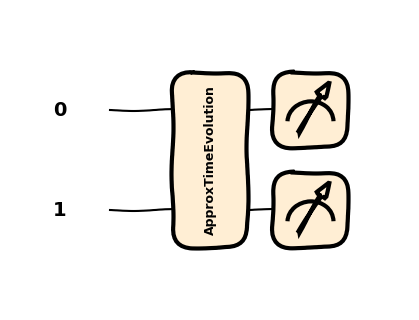

In [5]:
qml.draw_mpl(circuit)(t, n)
plt.show()

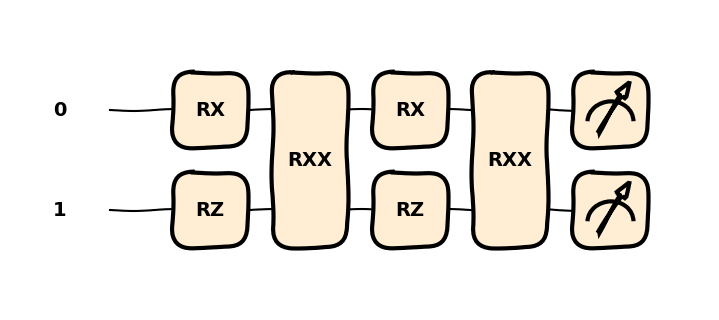

In [6]:
qml.draw_mpl(circuit, expansion_strategy='device')(t, n)
plt.show()

In [7]:
print(qml.draw(circuit, expansion_strategy='device')(t, n))

0: ──RX(1.00)─╭RXX(0.50)──RX(1.00)─╭RXX(0.50)─┤  <Z>
1: ──RZ(1.00)─╰RXX(0.50)──RZ(1.00)─╰RXX(0.50)─┤  <Z>


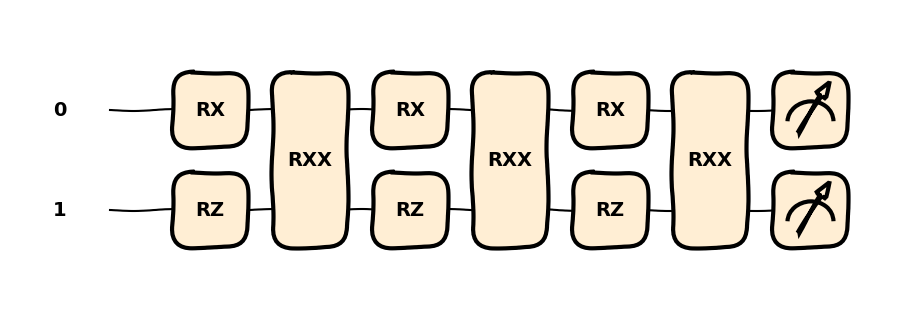

In [8]:
qml.draw_mpl(circuit, expansion_strategy='device')(t, 3)
plt.show()

In [9]:
@qml.qnode(dev)
def circuit_true(t):
    qml.evolve(H, coeff=1)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

In [10]:
print(qml.draw(circuit_true)(t))

0: ─╭Exp(-1.00j 𝓗(1.00,1.00,0.50))─┤  <Z>
1: ─╰Exp(-1.00j 𝓗(1.00,1.00,0.50))─┤  <Z>


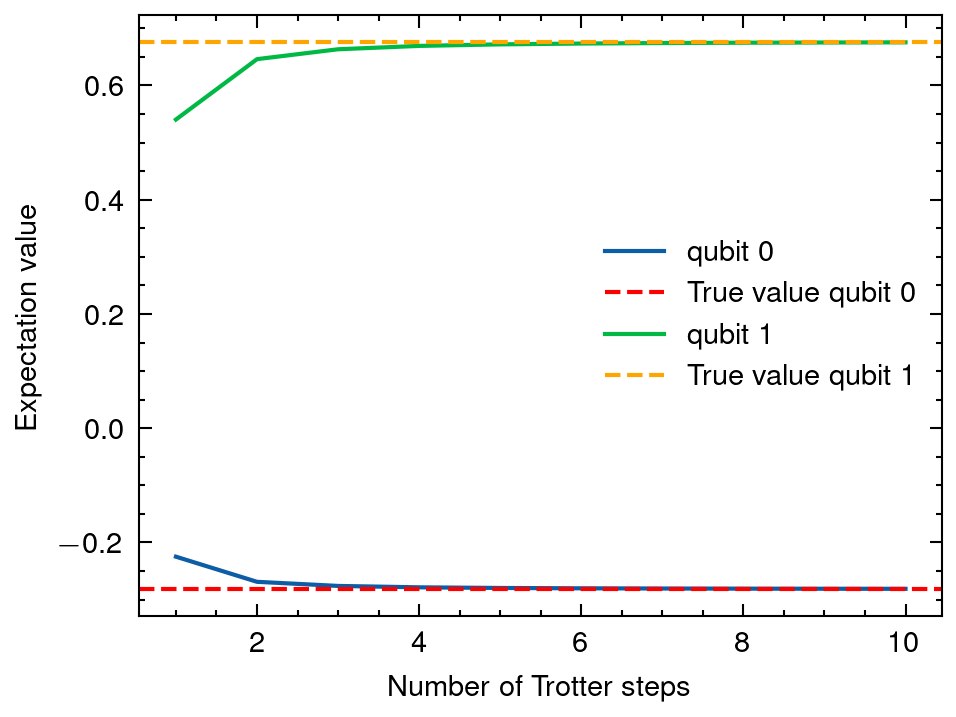

In [11]:
with plt.style.context(['science', 'nature']):
    data_0 = []
    data_1 = []
    for n in range(1, 11):
        data_0.append(circuit(t, n)[0].item())
        data_1.append(circuit(t, n)[1].item())

    true_0 = circuit_true(t)[0].item()
    true_1 = circuit_true(t)[1].item()
    
    plt.figure(dpi=300)
    plt.plot(range(1, 11), data_0, label="qubit 0")
    plt.axhline(true_0, linestyle="--", color="red", label="True value qubit 0")
    plt.plot(range(1, 11), data_1, label="qubit 1")
    plt.axhline(true_1, linestyle="--", color="orange", label="True value qubit 1")
    plt.xlabel("Number of Trotter steps")
    plt.ylabel("Expectation value")
    plt.legend()
    plt.tight_layout()
    plt.show()

## Layering Circuits

For Quantum Neural Networks (QNNs), repeated application of a circuit is common. This is known as layering.
In pennylane, we can use the `qml.layer` function to apply a circuit multiple times.

In [12]:
def circ(theta):
    qml.RX(theta, wires=0)
    qml.Hadamard(wires=1)
    qml.CNOT(wires=[0, 1])

@qml.qnode(dev)
def circuit(theta):
    circ(theta)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

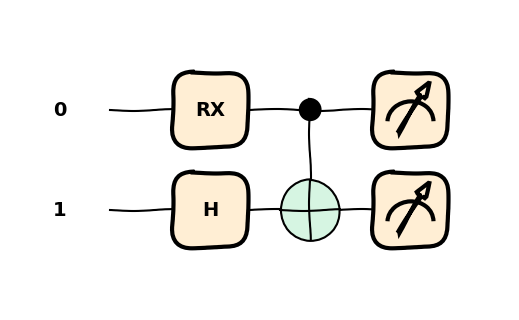

In [13]:
qml.draw_mpl(circuit)(0.5)
plt.show()

In [14]:
@qml.qnode(dev)
def circuit(params):
    qml.layer(circ, 3, params)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

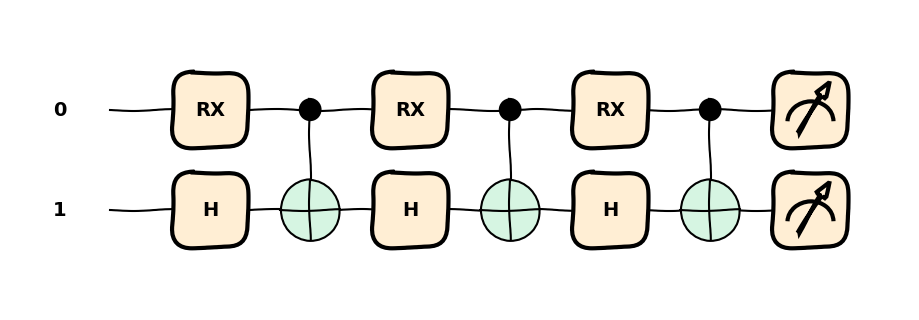

In [15]:
qml.draw_mpl(circuit)(np.array([0.1, 0.2, 0.3]))
plt.show()

## QAOA

The Quantum Approximate Optimization Algorithm (QAOA) is a well-known algorithm that can be used to find approximate solutions to combinatorial optimization problems.
The QAOA algorithm is composed of two types of unitary operators: the cost unitary operator and the mixer unitary operator. The cost unitary operator is defined as

$$
U_C(\gamma) = e^{-i\gamma H_C},
$$

where $H_C$ is the cost Hamiltonian. The mixer unitary operator is defined as

$$
U_M(\beta) = e^{-i\beta H_M},
$$

where $H_M$ is the mixer Hamiltonian.

The QAOA algorithm is composed of $p$ layers of the cost and mixer unitary operators. The QAOA circuit is given by

$$
U(\boldsymbol{\gamma}, \boldsymbol{\beta}) = U_M(\beta_p) U_C(\gamma_p) \cdots U_M(\beta_1) U_C(\gamma_1),
$$

where $\boldsymbol{\gamma} = [\gamma_1, \ldots, \gamma_p]$ and $\boldsymbol{\beta} = [\beta_1, \ldots, \beta_p]$ are the parameters of the QAOA circuit.


In this notebook, we will show how to implement a QAOA circuit to solve the minimum vertex cover problem.

In [18]:
import networkx as nx
from pennylane import qaoa

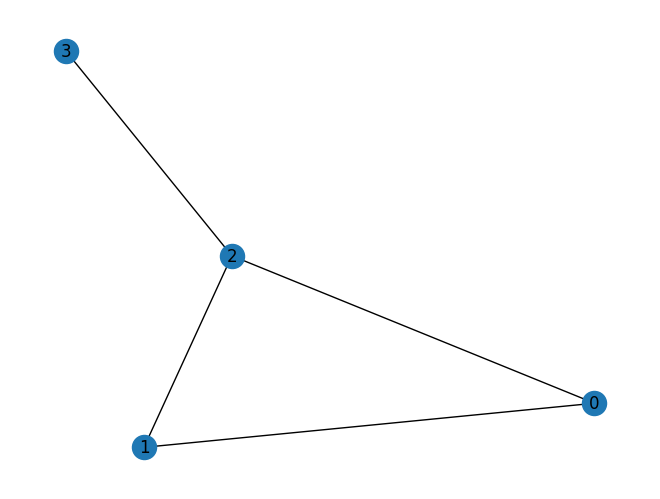

In [17]:
edges = [(0,1), (1,2), (2,0), (2,3)]
graph = nx.Graph(edges)

nx.draw(graph, with_labels=True)
plt.show()

In this graph, there are two minimum vertex covers: $\{0, 2\}$ and $\{1, 2\}$.
These can be represented as bitstrings $|1010\rangle$ and $|0110\rangle$, respectively.

In this case, the cost Hamiltonian has two ground states, $|1010\rangle$ and $|0110\rangle$.
The mixer Hamiltonian is just non-commuting sum of Pauli-X operations on each node of the graph.

For the MVCP, we minimize below cost functions:

$$
\begin{aligned}
F_1 &= \sum_{i=0}^{|V| - 1} x_i \quad & \text{Minimum vertex cover} \\
F_2 &= \sum_{(i, j) \in E} (1 - x_i)(1 - x_j) \quad & \text{Edge cover},
\end{aligned}
$$

where $i, j$ represent the nodes of the graph, $x_i$ is the binary variable that represents whether the node $i$ is in the vertex cover, and $E$ is the set of edges of the graph.
If we denote $S$ as the set of vertex covers, $x_i$ is 1 if $x \in S$ and 0 otherwise.

With these functions, the MVCP can be expressed as

$$
\underset{S}{\text{argmin}} \left( A F_1 + B F_2 \right),
$$

To solve the MVCP in the QAOA sense, we rewrite the variable $x_i$ as $s_i$:

$$
x_i = \frac{1 + s_i}{2}.
$$

It means that $s_i$ is 1 if $x_i = 1$ and -1 if $x_i = 0$.

Then , the cost function can be rewritten as

$$
\begin{aligned}
F = A\sum_{i=0}^{|V| - 1} \frac{1 + s_i}{2} + B\sum_{(i, j) \in E} \left(1 - \frac{1 + s_i}{2}\right)\left(1 - \frac{1 + s_j}{2}\right).
\end{aligned}
$$

In [19]:
cost_h, mixer_h = qaoa.min_vertex_cover(graph, constrained=False)

print("Cost Hamiltonian", cost_h)
print("Mixer Hamiltonian", mixer_h)

Cost Hamiltonian 0.75 * (Z(0) @ Z(1)) + 0.75 * Z(0) + 0.75 * Z(1) + 0.75 * (Z(0) @ Z(2)) + 0.75 * Z(0) + 0.75 * Z(2) + 0.75 * (Z(1) @ Z(2)) + 0.75 * Z(1) + 0.75 * Z(2) + 0.75 * (Z(2) @ Z(3)) + 0.75 * Z(2) + 0.75 * Z(3) + -1.0 * Z(0) + -1.0 * Z(1) + -1.0 * Z(2) + -1.0 * Z(3)
Mixer Hamiltonian 1 * X(0) + 1 * X(1) + 1 * X(2) + 1 * X(3)


$$
H_C=0.75 \sum_{(i, j) \in E}\left(Z_i \otimes Z_j\right)+0.75 \sum_i Z_i+\sum_i-Z_i
$$